Installing necessary dependencies and project set-up.

In [70]:
# Install required packages
!pip install torch torchvision timm transformers matplotlib scikit-learn opencv-python pandas seaborn umap-learn Pillow fontTools beautifulsoup4 requests tqdm


# Import necessary libraries
import torch
import torchvision
import timm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
from google.colab import drive
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
from fontTools.ttLib import TTFont
from google.colab import files
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests
import base64
import cv2
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive to access your dataset
drive.mount('/content/drive')

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2: Data Loading and Preprocessing Functions**

Indus Dataset

In [ ]:
# Ensure directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Set output directory in Google Drive
output_dir = "/content/drive/MyDrive/script_analysis/indus"
ensure_dir(output_dir)

print("Please upload the Indus sign list HTML file:")
uploaded = files.upload()

html_file_path = list(uploaded.keys())[0]
print(f"Processing file: {html_file_path}")

base_url = "https://www.indus.epigraphica.de/"

AUTH_USERNAME = "icit"
AUTH_PASSWORD = "seal123"
AUTH_HEADER = {
    "Authorization": "Basic " + base64.b64encode(f"{AUTH_USERNAME}:{AUTH_PASSWORD}".encode()).decode()
}

# Read the HTML file
with open(html_file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Find all table rows (skip the header)
rows = soup.find_all("tr")[1:]

# Collect sign data
sign_data = []
for row in rows:
    cols = row.find_all("td")

    if len(cols) < 12:
        continue  # Skip malformed rows

    # Extract sign code (1st column)
    sign_code = cols[0].text.strip()

    # Extract image source (7th column)
    img_tag = cols[6].find("img")
    if img_tag:
        img_src = img_tag["src"]
        img_url = base_url + img_src  # Construct full image URL

        # Extract frequency (12th column)
        try:
            frequency = int(cols[11].text.strip())
        except ValueError:
            continue  # Skip invalid frequency values

        # Store only if frequency > 2
        if frequency > 2:
            sign_data.append((sign_code, img_url))

# Download images with a progress bar
print(f"Downloading {len(sign_data)} images...")

session = requests.Session()
session.headers.update(AUTH_HEADER)  # Add Basic Auth header to all requests

for sign_code, img_url in tqdm(sign_data, desc="Downloading"):
    img_filename = os.path.join(output_dir, f"{sign_code}.jpg")

    response = session.get(img_url, stream=True)
    if response.status_code == 200:
        with open(img_filename, "wb") as img_file:
            img_file.write(response.content)
    else:
        print(f"Failed to download: {img_url} - Status {response.status_code}")

print("Download complete! All images are saved in:", output_dir)


Please upload the Indus sign list HTML file:


Saving ICIT.html to ICIT (5).html
Processing file: ICIT (5).html


Downloading:   0%|          | 0/391 [00:00<?, ?it/s]

Download complete! All images are saved in: /content/drive/MyDrive/script_analysis/indus


Proto-Cuneiform Dataset

In [ ]:
!git clone https://github.com/cdli-gh/proto-cuneiform_signs.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_cuneiform/
!cp proto-cuneiform_signs/archsigns/*.jpg /content/drive/MyDrive/script_analysis/proto_cuneiform/

Proto-Elamite Dataset

In [ ]:
!git clone https://github.com/sfu-natlang/pe-decipher-toolkit.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_mainforms/*.png /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_num/*.png /content/drive/MyDrive/script_analysis/proto_elamite/

Naxi Dongba Dataset

Font loaded successfully: BabelStoneNaxiLLC.ttf
Will generate images for 2122 characters (U+E000 to U+E849)


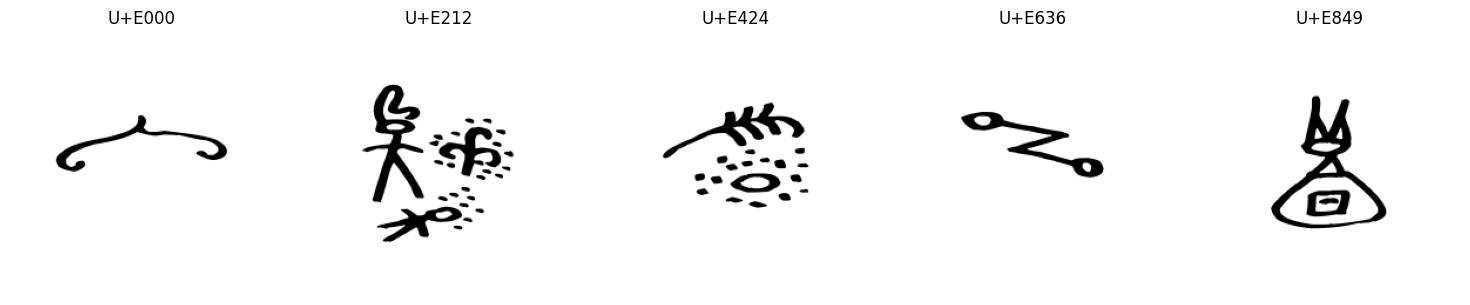

Do the sample characters look correct? (y/n): y


Generating images:   0%|          | 0/2122 [00:00<?, ?it/s]

Created 2122 character images in /content/drive/MyDrive/script_analysis/naxi_dongba/


'/content/drive/MyDrive/script_analysis/naxi_dongba/'

In [ ]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def char_to_image(char, font, image_size=224, bg_color=(255, 255, 255), text_color=(0, 0, 0)):
    img = Image.new('RGB', (image_size, image_size), color=bg_color)
    draw = ImageDraw.Draw(img)

    left, top, right, bottom = font.getbbox(char)
    text_width = right - left
    text_height = bottom - top

    # center text
    position = ((image_size - text_width) // 2 - left, (image_size - text_height) // 2 - top)

    draw.text(position, char, fill=text_color, font=font)

    return img

# set range within Dongba font
def create_dongba_dataset(font_path, output_dir, start_code=0xE000, end_code=0xE849, image_size=224):
    ensure_dir(output_dir)

    font_size = int(image_size * 0.7)
    try:
        font = ImageFont.truetype(font_path, font_size)
        print(f"Font loaded successfully: {font_path}")
    except Exception as e:
        print(f"Error loading font {font_path}: {e}")
        return

    char_list = [chr(code) for code in range(start_code, end_code + 1)]
    print(f"Will generate images for {len(char_list)} characters (U+{start_code:04X} to U+{end_code:04X})")

    # Get font name for naming files
    font_name = os.path.splitext(os.path.basename(font_path))[0]

    # Display a few sample characters
    plt.figure(figsize=(15, 3))
    sample_indices = np.linspace(0, len(char_list)-1, 5, dtype=int)

    for i, idx in enumerate(sample_indices):
        char = char_list[idx]
        img = char_to_image(char, font, image_size=image_size)
        plt.subplot(1, 5, i+1)
        plt.imshow(np.array(img))
        plt.title(f"U+{ord(char):04X}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Confirm to proceed
    proceed = input("Do the sample characters look correct? (y/n): ")
    if proceed.lower() != 'y':
        print("Operation cancelled.")
        return

    # Create an image for each character with a progress bar
    for i, char in tqdm(enumerate(char_list), total=len(char_list), desc="Generating images"):
        try:
            # Generate a safe filename
            char_code = f"{ord(char):04X}"
            filename = f"dongba_{char_code}.png"

            # Render the character
            img = char_to_image(char, font, image_size=image_size)

            # Save the image
            img.save(os.path.join(output_dir, filename))

        except Exception as e:
            print(f"Error processing character U+{ord(char):04X}: {e}")

    print(f"Created {len(char_list)} character images in {output_dir}")
    return output_dir

# Set output directory in your Google Drive
output_dir = '/content/drive/MyDrive/script_analysis/naxi_dongba/'

# Create the dataset with the specified Unicode range (U+E000 to U+E849)
create_dongba_dataset(
    font_path="BabelStoneNaxiLLC.ttf",
    output_dir=output_dir,
    start_code=0xE000,
    end_code=0xE849,
    image_size=224
)

Old Naxi dataset

In [39]:
!git clone https://github.com/infinite-hwb/VGTS.git
!mkdir -p /content/drive/MyDrive/script_analysis/old_naxi/
!cp VGTS/"DATA/DBH dataset"/"support image gallery/images"/*.jpg /content/drive/MyDrive/script_analysis/old_naxi/

TYC dataset

Load all datasets. Preprocessing (pad to square and denoise older Naxi glyphs)

Indus dataset: 391 images found
Visualizing preprocessing for a sample from Indus


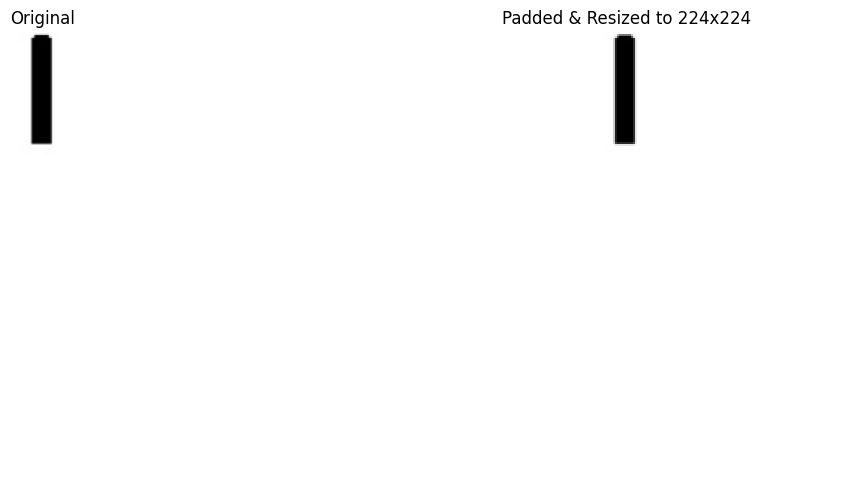

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Cuneiform dataset: 2089 images found
Visualizing preprocessing for a sample from Proto-Cuneiform


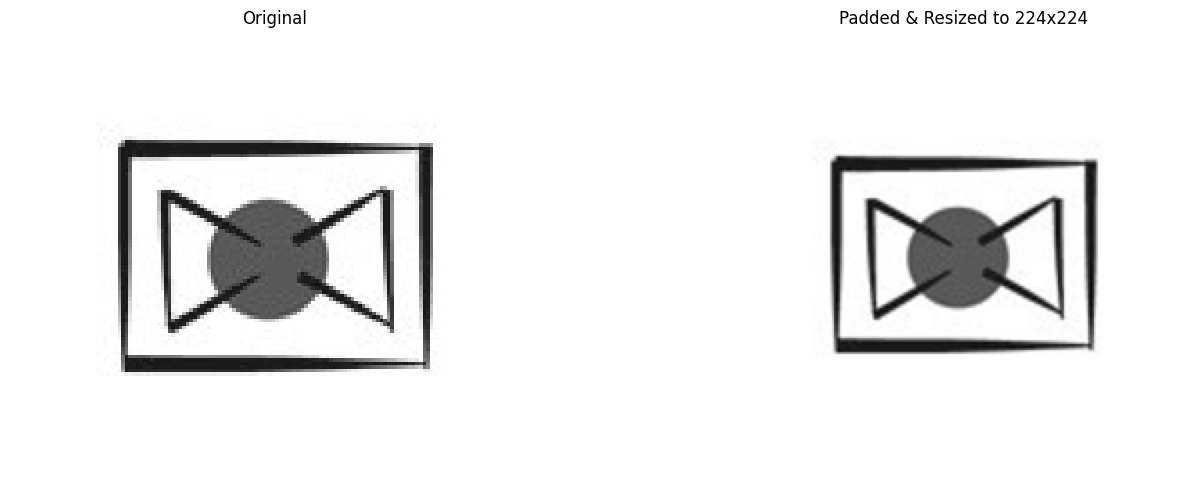

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Elamite dataset: 1510 images found
Visualizing preprocessing for a sample from Proto-Elamite


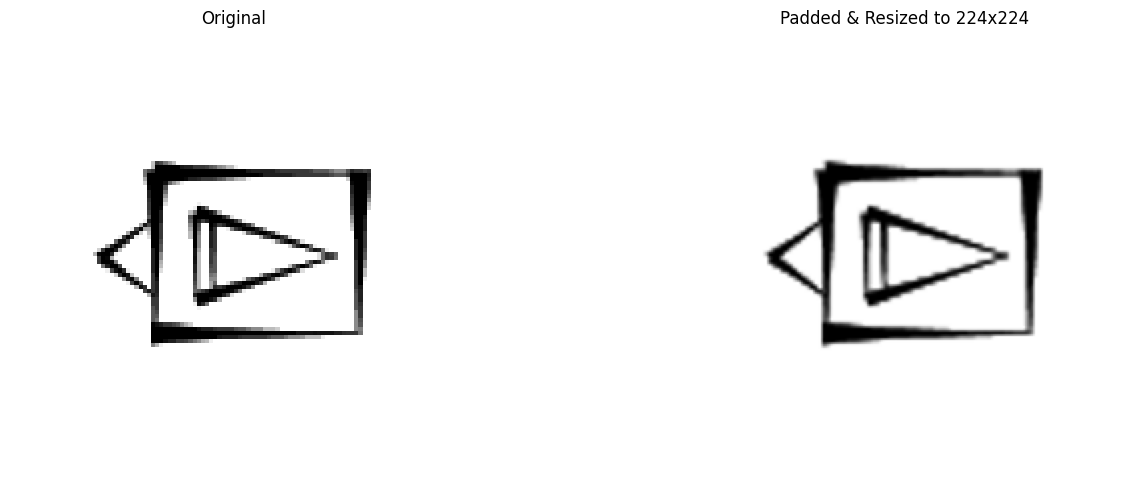

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Naxi Dongba dataset: 2122 images found
Visualizing preprocessing for a sample from Naxi Dongba


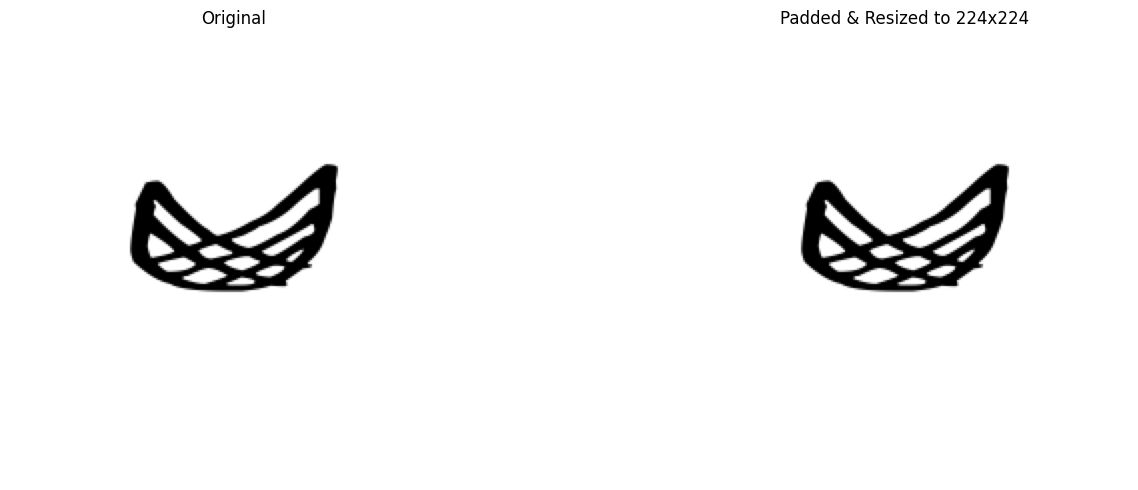

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Old Naxi dataset: 253 images found
Visualizing preprocessing for a sample from Old Naxi


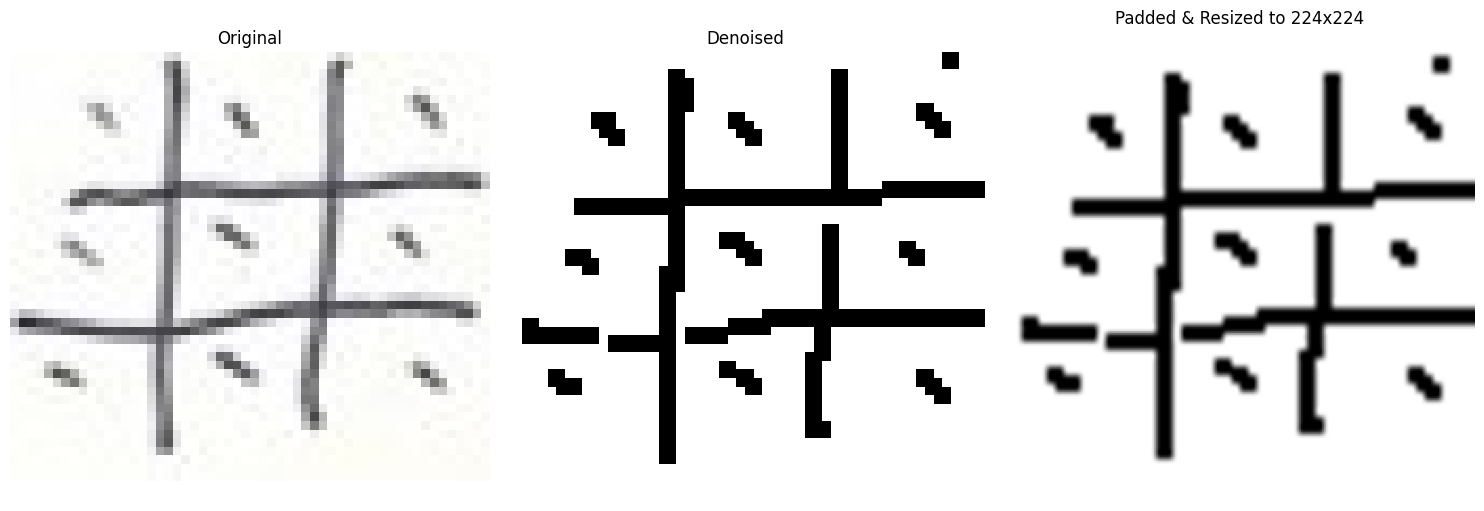

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Creating combined dataloader with selective denoising (only old Naxi)...
Combined dataloader created with 6365 total images


In [53]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# Set up paths to your datasets
INDUS_PATH = '/content/drive/MyDrive/script_analysis/indus/'
PROTO_CUNEIFORM_PATH = '/content/drive/MyDrive/script_analysis/proto_cuneiform/'
PROTO_ELAMITE_PATH = '/content/drive/MyDrive/script_analysis/proto_elamite/'
NAXI_DONGBA_PATH = '/content/drive/MyDrive/script_analysis/naxi_dongba/'
OLD_NAXI_PATH = '/content/drive/MyDrive/script_analysis/old_naxi/'

class ScriptDataset(Dataset):
    def __init__(self, image_paths, transform=None, script_type=None, denoise_types=None):
        self.image_paths = image_paths
        self.transform = transform
        self.script_type = script_type
        # Set which script types should be denoised
        self.denoise_types = denoise_types or []

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            # Load image and convert to RGB
            image = Image.open(image_path).convert('RGB')

            # Apply denoising if this script type is in the denoise_types list
            if self.script_type in self.denoise_types:
                image = denoise_image(image)

            # Apply preprocessing
            if self.transform:
                image = self.transform(image)

            # Return image and script type (if provided)
            if self.script_type is not None:
                return image, self.script_type
            return image

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a placeholder in case of error
            if self.transform:
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder
            else:
                placeholder = Image.new('RGB', (224, 224), color='white')
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder

def denoise_image(image):
    """
    Apply denoising to the image.
    This function combines multiple methods to handle different types of noise.
    """
    # Convert PIL to numpy for OpenCV operations
    np_image = np.array(image)

    # Convert to grayscale if it's a color image (for processing)
    is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
    if is_color:
        gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_image.copy()

    # Apply adaptive thresholding to handle uneven lighting (for binary glyph images)
    # This works well for scripts carved or written on varied surfaces
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Apply morphological operations to remove small noise
    kernel = np.ones((2, 2), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Apply non-local means denoising (better preserves edges than Gaussian)
    denoised = cv2.fastNlMeansDenoising(morphed, None, 10, 7, 21)

    # Convert back to original format
    if is_color:
        # Create a 3-channel image from the denoised grayscale
        result = np.stack([denoised] * 3, axis=2)
    else:
        result = denoised

    return Image.fromarray(result)

def pad_to_square(image, background_color='white'):
    """
    Custom function to pad an image to square without distortion.
    Uses white background (or specified color) instead of black.
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        np_image = np.array(image)
    else:
        np_image = image

    height, width = np_image.shape[:2]

    # Determine the size of the square (max of height and width)
    size = max(height, width)

    # Create a square canvas with white background
    if len(np_image.shape) == 3:  # Color image
        if background_color == 'white':
            square = np.ones((size, size, 3), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size, 3), dtype=np.uint8)
    else:  # Grayscale
        if background_color == 'white':
            square = np.ones((size, size), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size), dtype=np.uint8)

    # Calculate padding to center the image
    pad_height = (size - height) // 2
    pad_width = (size - width) // 2

    # Place the original image in the center of the square
    if len(np_image.shape) == 3:  # Color image
        square[pad_height:pad_height+height, pad_width:pad_width+width, :] = np_image
    else:  # Grayscale
        square[pad_height:pad_height+height, pad_width:pad_width+width] = np_image

    # Convert back to PIL if input was PIL
    if isinstance(image, Image.Image):
        return Image.fromarray(square)
    return square

class SquarePad:
    """
    Custom transform to pad images to square while preserving aspect ratio.
    """
    def __init__(self, background_color='white'):
        self.background_color = background_color

    def __call__(self, image):
        return pad_to_square(image, self.background_color)

def get_train_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for training images optimized for Swin Transformer.
    No augmentation as requested.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_test_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for validation/test images optimized for Swin Transformer.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to load image paths from a directory
def load_image_paths(directory):
    """
    Loads all valid image paths from a directory recursively.
    """
    image_paths = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return image_paths

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Create datasets and dataloaders
def create_dataloader(directory, transform, batch_size=32, script_type=None, shuffle=True, denoise_types=None):
    """
    Creates a DataLoader for a given directory of images.

    Args:
        directory: Path to image directory
        transform: Transforms to apply to images
        batch_size: Batch size for DataLoader
        script_type: Label for the script type
        shuffle: Whether to shuffle the data
        denoise_types: List of script types to apply denoising to
    """
    image_paths = load_image_paths(directory)

    if len(image_paths) == 0:
        print(f"Warning: No images found in {directory}")

    dataset = ScriptDataset(image_paths, transform, script_type, denoise_types=denoise_types)

    # Use fewer workers for Colab compatibility
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,  # Adjusted for Colab
        pin_memory=True
    )

def visualize_preprocessing(image_path, img_size=224, apply_denoise=False):
    """
    Visualizes the steps of preprocessing to verify the glyph is properly handled.
    """
    # Load original image
    original = Image.open(image_path).convert('RGB')

    # Apply denoising if enabled
    if apply_denoise:
        denoised = denoise_image(original)
        # Apply square padding
        padded = pad_to_square(denoised, 'white')
    else:
        # Apply square padding
        padded = pad_to_square(original, 'white')

    # Resize
    resized = padded.resize((img_size, img_size))

    # Display all steps
    fig, axes = plt.subplots(1, 3 if apply_denoise else 2, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    if apply_denoise:
        axes[1].imshow(denoised, cmap='gray')
        axes[1].set_title("Denoised")
        axes[1].axis('off')

        axes[2].imshow(resized)
        axes[2].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[2].axis('off')
    else:
        axes[1].imshow(resized)
        axes[1].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Verify that we can load the datasets and check preprocessing
def check_dataset(path, dataset_name, apply_denoise=False):
    """
    Checks that a dataset can be loaded and visualizes a sample with preprocessing.
    """
    paths = load_image_paths(path)
    print(f"{dataset_name} dataset: {len(paths)} images found")

    if len(paths) > 0:
        # Display original and preprocessed images
        print(f"Visualizing preprocessing for a sample from {dataset_name}")
        visualize_preprocessing(paths[0], apply_denoise=apply_denoise)

        # Test with DataLoader to verify everything works end-to-end
        transform = get_test_transforms(background_color='white')

        # Only apply denoising to specified scripts
        denoise_types = ["Old Naxi"] if apply_denoise else []

        loader = create_dataloader(
            path,
            transform,
            batch_size=1,
            script_type=dataset_name,
            denoise_types=denoise_types
        )

        # Load one batch
        try:
            sample, label = next(iter(loader))
            print(f"Successfully loaded a batch: shape={sample.shape}")
        except Exception as e:
            print(f"Error loading batch: {e}")
    else:
        print(f"No images found in {path}")

def check_all_datasets():
    # Check preprocessing on each dataset
    # Only apply denoising to Old Naxi
    check_dataset(INDUS_PATH, "Indus", apply_denoise=False)
    check_dataset(PROTO_CUNEIFORM_PATH, "Proto-Cuneiform", apply_denoise=False)
    check_dataset(PROTO_ELAMITE_PATH, "Proto-Elamite", apply_denoise=False)
    check_dataset(NAXI_DONGBA_PATH, "Naxi Dongba", apply_denoise=False)
    check_dataset(OLD_NAXI_PATH, "Old Naxi", apply_denoise=True)

# Create a combined dataloader for all script types with selective denoising
def create_combined_dataloader(batch_size=32, img_size=224, shuffle=True):
    """
    Creates a combined dataloader for all script types.
    Only applies denoising to Old Naxi.
    """
    transform = get_train_transforms(img_size=img_size)

    # List of script types to denoise
    denoise_types = ["Old Naxi"]

    datasets = []

    # Create dataset for each script type
    if os.path.exists(INDUS_PATH):
        indus_paths = load_image_paths(INDUS_PATH)
        if indus_paths:
            datasets.append(ScriptDataset(indus_paths, transform, "Indus", denoise_types))

    if os.path.exists(PROTO_CUNEIFORM_PATH):
        cuneiform_paths = load_image_paths(PROTO_CUNEIFORM_PATH)
        if cuneiform_paths:
            datasets.append(ScriptDataset(cuneiform_paths, transform, "Proto-Cuneiform", denoise_types))

    if os.path.exists(PROTO_ELAMITE_PATH):
        elamite_paths = load_image_paths(PROTO_ELAMITE_PATH)
        if elamite_paths:
            datasets.append(ScriptDataset(elamite_paths, transform, "Proto-Elamite", denoise_types))

    if os.path.exists(NAXI_DONGBA_PATH):
        dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
        if dongba_paths:
            datasets.append(ScriptDataset(dongba_paths, transform, "Naxi Dongba", denoise_types))

    if os.path.exists(OLD_NAXI_PATH):
        old_naxi_paths = load_image_paths(OLD_NAXI_PATH)
        if old_naxi_paths:
            datasets.append(ScriptDataset(old_naxi_paths, transform, "Old Naxi", denoise_types))

    # Combine all datasets
    combined_dataset = torch.utils.data.ConcatDataset(datasets)

    return DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

# Run the dataset checker
check_all_datasets()

# Example: Create a combined dataloader with selective denoising
print("Creating combined dataloader with selective denoising (only old Naxi)...")
combined_loader = create_combined_dataloader(batch_size=16)
print(f"Combined dataloader created with {len(combined_loader.dataset)} total images")

# Data augmentation

Run augmentation

Creating combined dataloader with both original and augmented images...
Combined dataloader created with 6365 total images
